In [381]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle
import community
from statistics import mode
import seaborn as sn
import datetime
import random

In [285]:
g = nx.read_gpickle("popular_directors_network.gpickle")

In [3]:
g.number_of_nodes()

1273

In [4]:
g.number_of_edges()

217725

In [5]:
degrees = g.degree()
list_degrees_with_names = sorted(degrees, key=lambda x: x[1], reverse=True)

In [6]:
print('Director who has actors in common with most directors',list_degrees_with_names[0][0])
print('Has actors in common with ' + str(list_degrees_with_names[0][1]) + ' different directors')

Director who has actors in common with most directors Woody Allen
Has actors in common with 1061 different directors


In [7]:
x= list_degrees_with_names[len(list_degrees_with_names)-2][0]
g.node[x]['movies']

[211247, 396535, 389868, 91088]

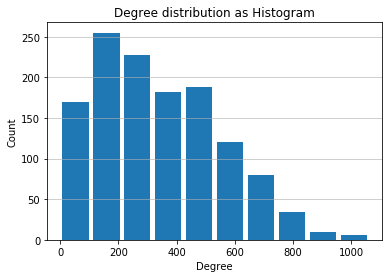

In [9]:
plt.hist(list(dict(nx.degree(g)).values()), rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title("Degree distribution as Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

### Does the network have a power law degree distribution?

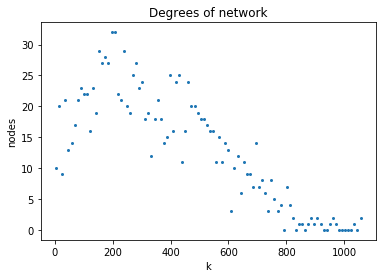

In [383]:
degrees = [o[1] for o in list(g.degree)]
h = np.histogram(degrees, bins=100)
avgValues = []
for i in range(len(h[1])-1):
    avgValues.append((h[1][i]+h[1][i+1])/2)
    
plt.plot(avgValues,h[0], 'o', markersize=2)
plt.xlabel('k')
plt.ylabel('nodes')
plt.title('Degrees of network')
plt.show()

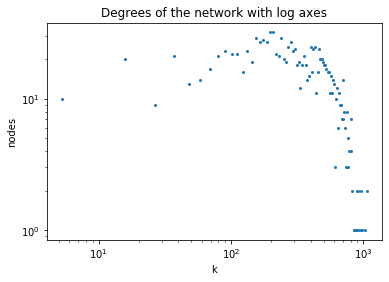

In [387]:
plt.yscale('log')
plt.xscale('log')
plt.plot(avgValues,h[0], 'o', markersize=2)
plt.xlabel('k')
plt.ylabel('nodes')
plt.title('Degrees of the network with log axes')
plt.show()

It does not really obey the power law but it is still a very broad distribution meaning that the difference between the minum degree and the maximum degree is very large. 

### Is the friendship paradox true in this network?

In [385]:
result = []
tries = 1000
for i in range(1,tries):
    random_node = random.choice(list(gc.nodes))
    degree = g.degree(random_node)
    neigbors = g.neighbors(random_node)
    avg = np.mean([o[1] for o in g.degree(neigbors)])
    result.append(avg > degree)
    

print('Paradox is true {} % of the time'.format((result.count(True)/ tries)*100 ))

Paradox is true 72.8 % of the time


In [386]:
degrees_list =[x[1] for x in gc.degree()]
print('average: ', np.average(degrees_list))
print('median: ', np.median(degrees_list))
print('mode: ', mode(degrees_list))
print('min: ', np.min(degrees_list))
print('max: ', np.max(degrees_list))

average:  342.33490566037733
median:  308.0
mode:  156
min:  5
max:  1061


In [11]:
print('Top 5 directors regarding degree')
for name,_ in (list_degrees_with_names)[0:5]:
    print(name)

Top 5 directors regarding degree
Woody Allen
Steven Spielberg
Ridley Scott
Martin Scorsese
Oliver Stone


In [66]:
gc = max(nx.connected_component_subgraphs(g), key=len)
len(list(nx.connected_component_subgraphs(g)))

2

In [13]:
betweeness_centrality = nx.betweenness_centrality(gc)

In [14]:
list_betweeness_centrality = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding betweeness centrality')
for name,d in (list_betweeness_centrality)[0:5]:
    print(name)

Top 5 directors regarding betweeness centrality
Ridley Scott
Woody Allen
Steven Spielberg
Martin Scorsese
Ron Howard


In [15]:
eigenvector_centrality = nx.eigenvector_centrality(gc)
list_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding eigenvector centrality')
for name,d in (list_eigenvector_centrality)[0:5]:
    print(name)

Top 5 directors regarding eigenvector centrality
Steven Spielberg
Woody Allen
Ridley Scott
Martin Scorsese
Oliver Stone


### The small world property
Does the small world propery hold in our network?

In [388]:
nx.diameter(gc)

4

$<d> = \frac{\log n}{\log <k>} 4$

In [389]:
avg_degree = np.average(degrees_list)
avg_distance = nx.average_shortest_path_length(gc)

In [390]:
np.log(gc.number_of_nodes())/np.log(avg_degree)

1.2249149367846073

In [391]:
avg_distance

1.7416893052071116

## Community detection

In [362]:
partition = community.best_partition(gc)
print('Modularity:', community.modularity(partition, gc))

Modularity: 0.22840253859234458


In [363]:
communities = {}
for key, item in partition.items():
    gc.node[key]["community"] = item
    if item not in communities:
        communities[item] = []
    communities[item].append(key)

In [364]:
for c in communities.items():
    print(str(c[0])+ ': ' + str(len(c[1])))

0: 477
1: 220
2: 335
3: 81
4: 112
5: 47


In [365]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gc, pos=None, iterations=5000)



100%|██████████| 5000/5000 [01:36<00:00, 51.81it/s]

BarnesHut Approximation  took  29.23  seconds
Repulsion forces  took  42.40  seconds
Gravitational forces  took  0.53  seconds
Attraction forces  took  18.92  seconds
AdjustSpeedAndApplyForces step  took  2.10  seconds


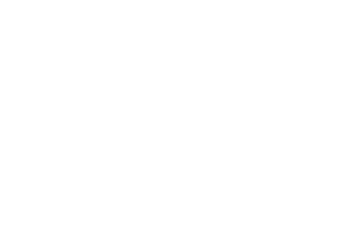

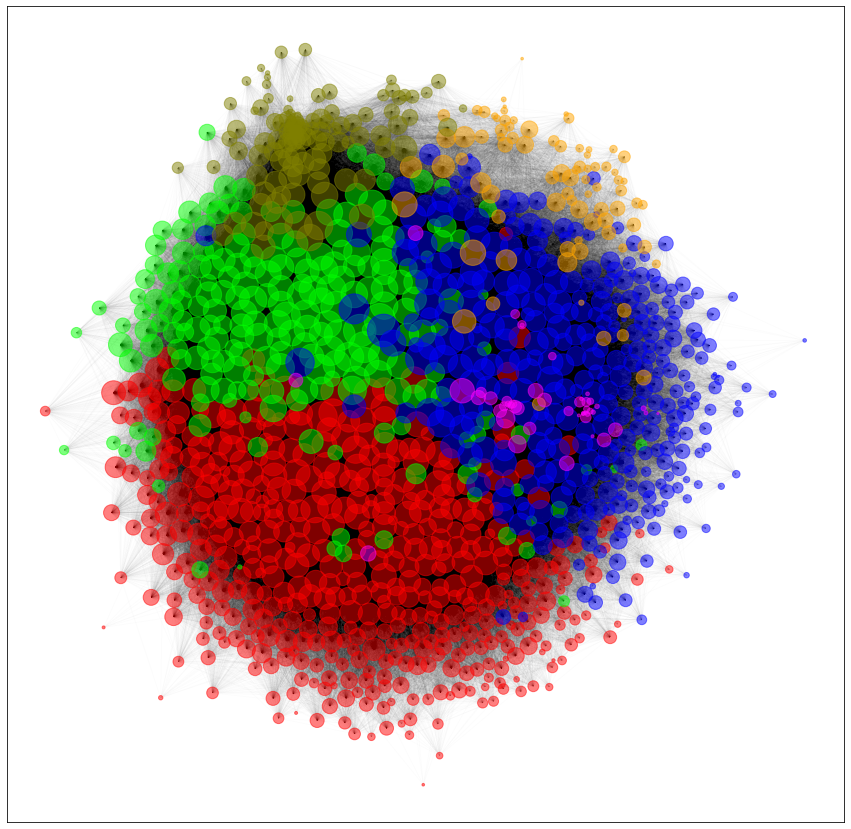

In [367]:
colours = ['red', 'lime', 'blue', 'orange', 'olive', 'magenta', 'Aqua', 'Brown', 'olive', 'pink', 'yellow', 'black', 'gray']
d = g.degree()
plt.axis('off')
plt.figure(figsize=(15,15))
for i,(_,com) in enumerate(communities.items()):
    com_degrees = [d[node] for node in com]
    nx.draw_networkx_nodes(gc,positions, nodelist=com,node_color=colours[i], node_size= com_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(gc, positions, alpha=0.01)
plt.show()

### Languages

In [254]:
# create dictionary for languages
# if directors have directed movies with languages other than english find the language that appeared the most times
# otherwise set language to english
# reason for not just setting language to majority: we lose some information about directors who have directed some 
# foreigh movies, but still mosty english, as their language will be set to english. 
lan_dict = {}
for d,l in nx.get_node_attributes(gc,'languages').items():
    foreign_l= [y for y in l if y != 'en']
    if len(foreign_l) == 0:
        main_l = 'en'
    else:
        main_l = max((foreign_l), key=foreign_l.count)
    if not main_l in lan_dict:
        lan_dict[main_l] = []
    lan_dict[main_l].append(d)

In [164]:
confusion_matrix = np.zeros((len(lan_dict), len(communities)))

for i, l in enumerate(lan_dict.items(), start=0):
    for j, c in enumerate(communities.items(),start=0):
        in_community = len(list(set(c[1]).intersection(l[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*in_community/total_in_community

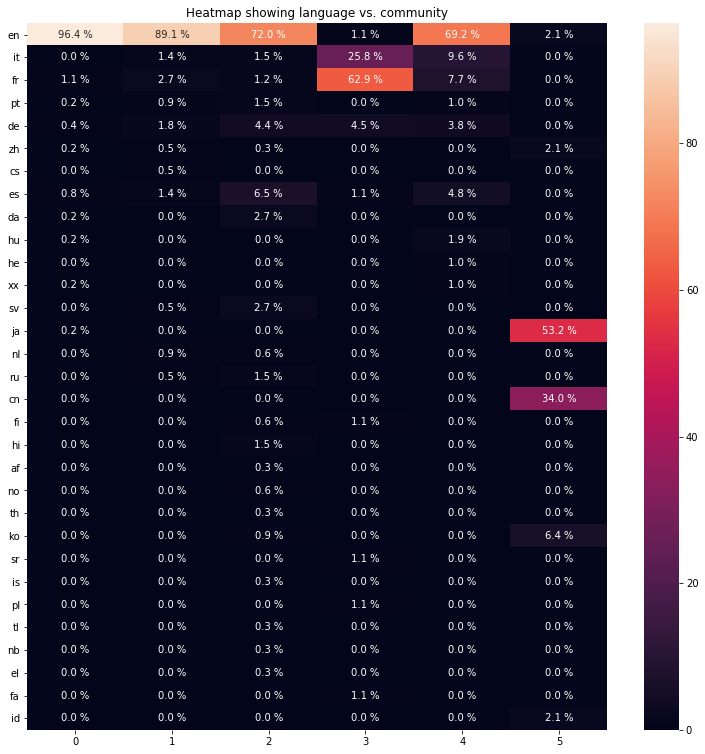

In [165]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in lan_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing language vs. community')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

Community 3 and 5 seem to be based on language. Community 3 mostly has mostly directors of french movies and some italian movies, community 5 mostly directors of japanese and cantonese movies. The other communities have mostly directors of english movies however community 2 does have a higher percentage of movies of many of the smaller languages than the other communities. 

### Genres

In [215]:
# create dictionary of genres and directors who have directed movies of that genre
# As most movies have multiple genres and many directors have directed multiple movies
# the same director might appear for multiple genres
genres_dict = {}
for d,genres in nx.get_node_attributes(gc,'genres').items():
    for genre in genres:
        if not genre in genres_dict:
            genres_dict[genre] = set()
        genres_dict[genre].add(d)

In [286]:
confusion_matrix = np.zeros((len(genres_dict), len(communities)))

for i, genre in enumerate(genres_dict.items(), start=0):
    directors_of_genre = len(set(genre[1]))
    for j, c in enumerate(communities.items(),start=0):
        in_community = len(list(set(c[1]).intersection(genre[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*(in_community/total_in_community)

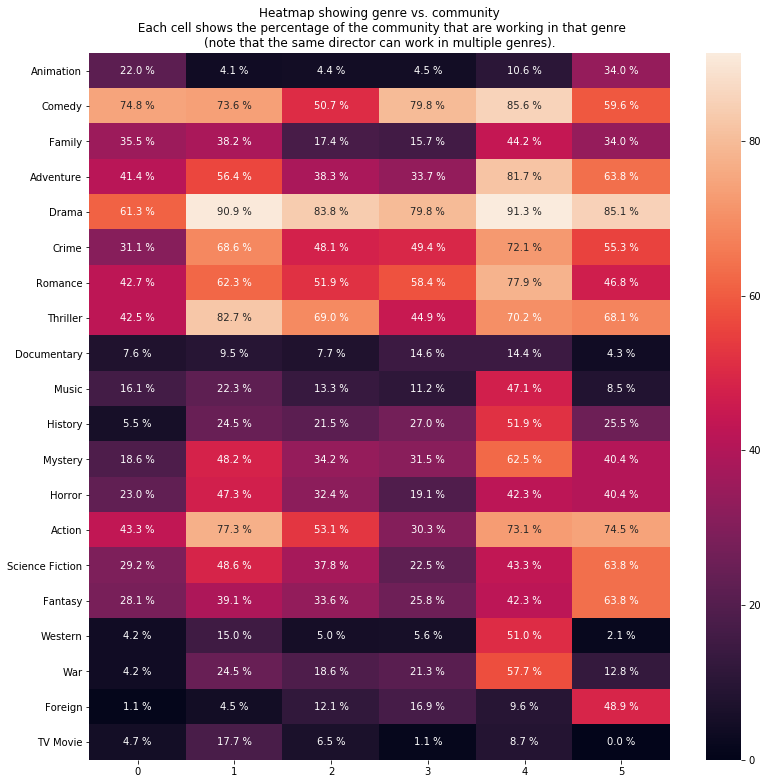

In [287]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in genres_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing genre vs. community\n Each cell shows the percentage of the community that are working in that genre\n(note that the same director can work in multiple genres).')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

All communities are a mix of multiple genres which makes sense since we know that directors and actors do not restrict themselves to a single genre. There are some genres that are quite common among all communities such as drama, comedy, romance, thriller and action. These are all genres that are somewhat general and a lot of movies will have these genres listed as their genre along with other more significant genres.

There are however some differences between the communities that might be of significans. Communty 4 has directors working in multiple genres that are not as common in the other communities such as music, history, mystery, western and war. 

Community 5 has a high percentage of directors working in the genres foreign, fantasy and science fiction. 

Community 1 has a high percentage of directors working in the genres thrillers, mystery, horror and science fiction. 

### Active period

In [238]:
# create dictionary of decade and directors who have directed movies in that decade
period_dict = {1910:[], 1920:[], 1930:[], 1940:[], 1950:[], 1960:[], 1970:[], 1980:[], 1990:[], 2000:[], 2010:[]}
for d in gc.nodes():
    first_movie = datetime.datetime.strptime(gc.node[d]['first_movie'], '%Y-%m-%d')
    last_movie = datetime.datetime.strptime(gc.node[d]['last_movie'], '%Y-%m-%d')
    for p in period_dict.items():
        period_start = datetime.datetime(p[0], 1, 1, 0, 0)
        period_end = datetime.datetime(p[0]+9, 12, 31, 0, 0)
        if last_movie >= period_start and first_movie <= period_end:
            period_dict[p[0]].append(d)

In [241]:
confusion_matrix = np.zeros((len(period_dict), len(communities)))

for i, p in enumerate(period_dict.items(), start=0):
    directors_in_period = len(set(p[1]))
    for j, c in enumerate(communities.items(),start=0):
        in_community =len(list(set(c[1]).intersection(p[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*(in_community/total_in_community)

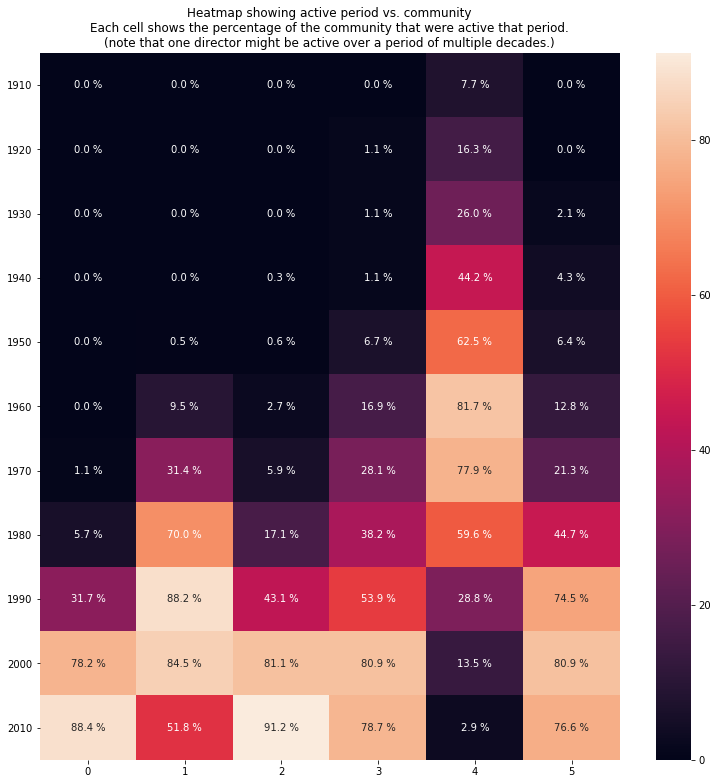

In [244]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in period_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing active period vs. community\nEach cell shows the percentage of the community that were active that period.\n(note that one director might be active over a period of multiple decades.)')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

From this figure we can see that community 4 consists mainly of older movies. It makes sense that the directors of older movies are grouped together as not many of the same actors are acting in older as well as newer movies. We can also spot that directors of movies released after year 2000 are in community 0 and 2, while directors of movies from 1980-2000 are more dominant in community 1. Community 3 and 5 are not as concentrated on a specific period but are spread out from 1970 until 2020.

### Rating

In [137]:
# create dictionary of decade and directors who have directed movies in that decade

length = len(ratings)
low = ratings[int(round(length/5))]
medium_low = ratings[int(round(length/5)*2)]
medium = ratings[int(round(length/5)*3)]
medium_high = ratings[int(round(length/5)*4)]

ratings_dict = {'low':[], 'medium_low':[], 'medium':[], 'medium_high':[], 'high':[]}

for d,rating in nx.get_node_attributes(gc,'rating').items():
    if rating <= low:
        ratings_dict['low'].append(d)
    elif rating <= medium_low:
        ratings_dict['medium_low'].append(d)
    elif rating <= medium:
        ratings_dict['medium'].append(d)
    elif rating <= medium_high:
        ratings_dict['medium_high'].append(d)
    else:
        ratings_dict['high'].append(d)

In [245]:
confusion_matrix = np.zeros((len(ratings_dict), len(communities)))

for i, r in enumerate(ratings_dict.items(), start=0):
    directors_of_rating = len(set(r[1]))
    for j, c in enumerate(communities.items(),start=0):
        in_community =len(list(set(c[1]).intersection(r[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*(in_community/total_in_community)

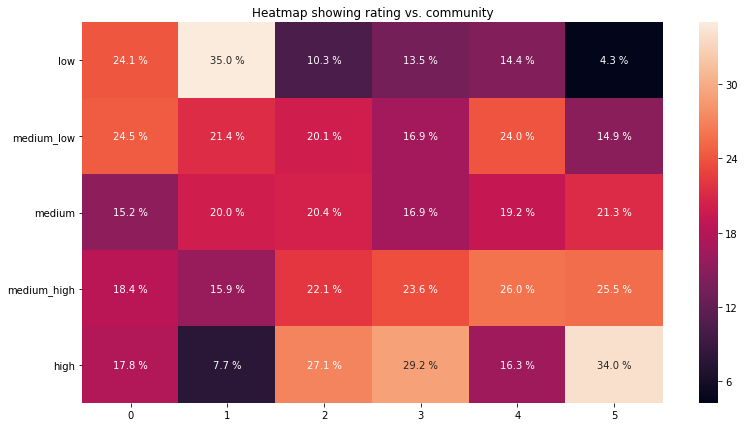

In [246]:
plt.figure(figsize = (13,7))
yticklabels = [l for l in ratings_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing rating vs. community')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

There does not seem to be a high correlation between rating and communities. Community 0 and 1 have a larger part of low rating directors while community 2, 3 and 5 have a larger part of high rating directors. Community 4 has the largest part around the average rating. However there is not a huge difference in the numbers.

### Conclusion about communities
So what can we say about the communities? First of all, the modularity is not significantly high, so the communities are not that solid. We examined different groupings of the directors to see if there is a correlation with the found communities. We tried grouping the directors by language, by genre, by active period and by rating. We discovered the following about the communities:
- Community 0 consists almost solely of directors of english movies. Regarding active period it consists mostly of directors active in the recent decades.
- Community 1 also consist mainly of directors of english movies. It has a high percentage of directors working in drama, thrillers and action. Over half of the community has been rated below medium and most directors were active in the years 1980-2010.
- Community 2 has a higher number of percentage of directors working in many of the smaller languages than the other communities. It consists mainly of directors active after 1990. Almost haf of the community has been rated above average. 
- Community 3 consists mainly of directors of french and italian movies. Most of the directors in that community are working with commedy and drama. The directors have been active in the last 50 or so years. Over half of the community has been rated above average.
- Community 4 is characteries as being the community of directors of older movies. Most directors were active in the years 1940-1990. The genres are also a bit different than of the other communities. These directors were working more in the genres music, history, mystery, western and war which are genres that were more popular a few decades ago than they are today.
- Community 5 consists mainly of directors of japanese and cantonese movies. These directors are directing foreign, fantasy and science fiction movies and a more than a third of the community has received a high rating. 

The analysis showed that some of the communities seem to be defined by attributes such as language (3 and 5) and active period (4) while the others are more mixed and it's harder to distinguish what makes the community. 


So what in communities are our most central directors regarding eigenvector centrality? My guess would be in the mixed communities 0, 1 or 2. These are afterall also the largest communities and they seem to hold the more mainstreem directors.

In [255]:
for name,d in (list_eigenvector_centrality)[0:5]:
    print(name +': ' + str(partition[name]))

Steven Spielberg: 2
Woody Allen: 1
Ridley Scott: 2
Martin Scorsese: 1
Oliver Stone: 1


In [368]:
high_rating_gc.number_of_nodes()

137

In [355]:
high_rating = (n for n in g if g.node[n]['rating']>7)
high_rating_graph = g.subgraph(list(high_rating))
high_rating_gc = max(nx.connected_component_subgraphs(high_rating_graph), key=len)


In [369]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

positions_high_rating = forceatlas2.forceatlas2_networkx_layout(high_rating_gc, pos=None, iterations=5000)

100%|██████████| 5000/5000 [00:03<00:00, 1393.08it/s]

BarnesHut Approximation  took  0.79  seconds
Repulsion forces  took  2.02  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.24  seconds


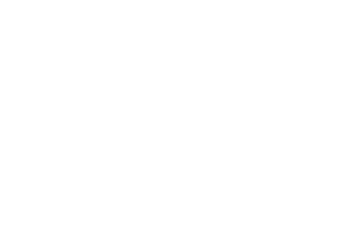

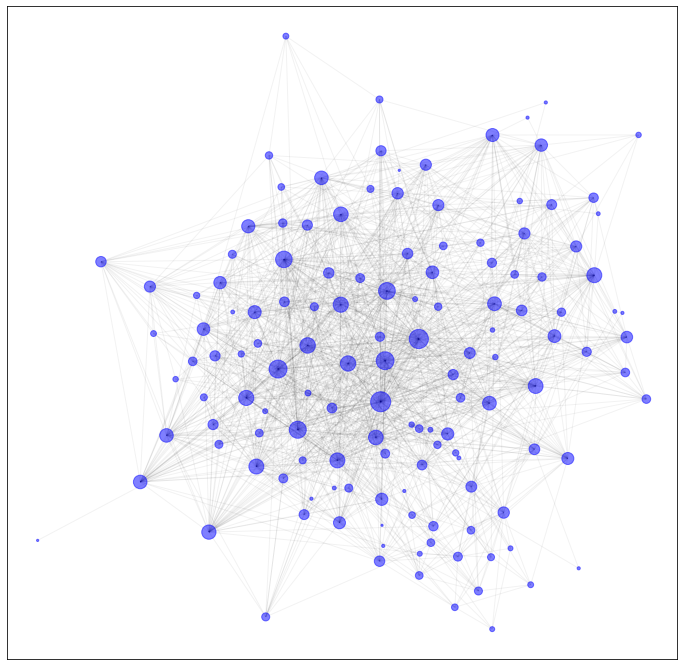

In [370]:
d = high_rating_gc.degree()

degrees = [d[n]*5 for n in high_rating_gc.nodes()]
plt.axis('off')
plt.figure(figsize=(12,12)) 
nx.draw_networkx_nodes(high_rating_gc, positions_high_rating, node_color='blue', node_size= degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(high_rating_gc, positions_high_rating, alpha=0.05)
plt.show()

In [373]:
partition = community.best_partition(high_rating_gc)
print('Modularity:', community.modularity(partition, high_rating_gc))

Modularity: 0.2597642432262952


In [374]:
communities = {}
for key, item in partition.items():
    gc.node[key]["community"] = item
    if item not in communities:
        communities[item] = []
    communities[item].append(key)
for c in communities.items():
    print(str(c[0])+ ': ' + str(len(c[1])))

0: 39
1: 21
2: 26
3: 39
4: 4
5: 8


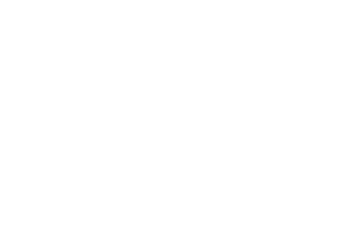

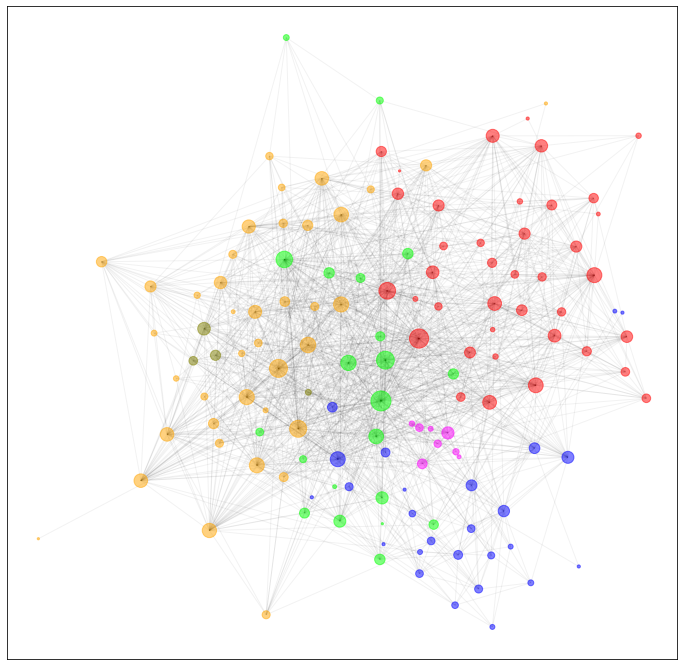

In [376]:
colours = ['red', 'lime', 'blue', 'orange', 'olive', 'magenta', 'Aqua', 'Brown', 'olive', 'pink', 'yellow', 'black', 'gray']

plt.axis('off')
plt.figure(figsize=(12,12))
for i,(_,com) in enumerate(communities.items()):
    com_degrees = [d[node] * 5 for node in com]
    nx.draw_networkx_nodes(high_rating_gc,positions_high_rating, nodelist=com,node_color=colours[i], node_size= com_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(high_rating_gc, positions_high_rating, alpha=0.05)
plt.show()

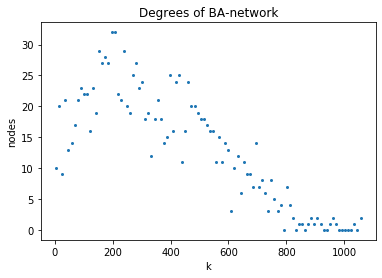

In [378]:
degrees = [o[1] for o in list(g.degree)]
h = np.histogram(degrees, bins=100)
avgValues = []
for i in range(len(h[1])-1):
    avgValues.append((h[1][i]+h[1][i+1])/2)
    
plt.plot(avgValues,h[0], 'o', markersize=2)
plt.xlabel('k')
plt.ylabel('nodes')
plt.title('Degrees of network')
plt.show()